#### Importing libraries

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random 
import heapq
import seaborn as sns
from tqdm import tqdm

#### Loading the graph from csv file

In [6]:
def build_graph():
    df = pd.read_csv('top_1000_by_liquidity.csv')
    # G = nx.from_pandas_edgelist(df, source='token0.symbol', target='token1.symbol', edge_attr='reserveUSD', create_using=nx.Graph().to_undirected())
    edges = pd.DataFrame(
    {
        "source": df["token0.symbol"],
        "target": df["token1.symbol"],
        "weight": df["reserveUSD"],
    }
    )
    G = nx.from_pandas_edgelist(edges, edge_attr=True, create_using=nx.Graph().to_undirected())
    return G

In [7]:
def drop_weights(G):
    '''Drop the weights from a networkx weighted graph.'''
    for node, edges in nx.to_dict_of_dicts(G).items():
        for edge, attrs in edges.items():
            attrs.pop('weight', None)

G = build_graph()
print(nx.is_weighted(G))
G_unweighted = G
drop_weights(G_unweighted) 
print(nx.is_weighted(G_unweighted))

True
False


#### Functions to remove nodes based on logic

In [4]:
def remove_node_randomly(G, num):
    """ Remove Node Randomly

    This function removes nodes randomly from the full graph and returns the remaining graph

    :param G: the input graph
    :param num: number of nodes to remove at random
    :return g_rem: the remaining graph with nodes randomly removed
    """
    g_rem = G.copy()
    nodes_g = list(g_rem.nodes)
    ran_sample = random.sample(nodes_g, num)
    g_rem.remove_nodes_from(ran_sample)
    
    return g_rem


In [5]:
def remove_most_important_nodes(G, num, centrality_measure):
    """ Remove Most Important Nodes

    This function removes the most important node from the input graph, with the importance of the node being determined by the centrality measure

    :param num: the number of most important nodes to remove
    :param G: the input graph
    :param centrality_measure: the centrality measure used  #todo: verify this with Kartikey
    :return g_rem: the remaining graph with the most important node removed
    """
    g_rem = G.copy()
    rem_sample = heapq.nlargest(num, centrality_measure, key=centrality_measure.get)
    g_rem.remove_nodes_from(rem_sample)

    return g_rem


#### Function to check robustness - based on Diameter of the Graph

In [5]:
def robustness():
    """ Robustness

    This function calculates the min, max and avg. diameter across all the subgraphs in the network by iteratively removing one node randomly from the input graph

    :return: list of all the min, max, and avg. diameter values
    """
    G = build_graph()
    num_nodes = len(list(G.nodes()))

    diameter_list_min = []
    diameter_list_max = []
    diameter_list_average = []
    num_of_sugraphs_list = []

    removed_nodes = [0]
    nodes_to_be_deleted = 1
    rem_counter  = 0 

    for x in tqdm(range(int(num_nodes/nodes_to_be_deleted))):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            num_of_sugraphs_list.append(len(list_sub_graphs))
            diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
            diameter_list_min.append(min(diameters))
            diameter_list_max.append(max(diameters))
            diameter_list_average.append(sum(diameters)/len(diameters))

        G_new = remove_node_randomly(G, nodes_to_be_deleted)
        rem_counter = rem_counter + nodes_to_be_deleted
        
        list_sub_graphs = list(G_new.subgraph(c) for c in nx.connected_components(G_new))

        num_of_sugraphs_list.append(len(list_sub_graphs))
        diameters = [nx.diameter(subgraph) for subgraph in list_sub_graphs]
        diameter_list_min.append(min(diameters))
        diameter_list_max.append(max(diameters))
        diameter_list_average.append(sum(diameters)/len(diameters))
        removed_nodes.append(rem_counter)

    plt.figure(figsize=(12,8))
    plt.title("Variation of the diameter values across all subgraphs of the network")
    plt.xlabel("Number of nodes removed")
    plt.ylabel("diameter values across all subgraphs")
    plt.plot(removed_nodes, diameter_list_min, linestyle="-", marker="o", label="min diameter across all subgraphs", color="blue", alpha=0.2)
    plt.plot(removed_nodes, diameter_list_max, linestyle="-", marker="o", label="max diameter across all subgraphs", color="blue", alpha=0.2)
    plt.plot(removed_nodes, diameter_list_average, linestyle="-", marker="o", label="average diameter across all subgraphs", color="red")
    plt.legend()
    plt.show()

    

In [8]:
def compute_centrality(G):
    """ Compute Centrality

    This function computes different centrality measures for the input graph. The following centrality measures are comptued:
        Degree centrality, betweenness centrality, closeness centrality, eigenvector centrality,

    :param G: the input graph
    :return: centrality measures of the graph
    """
    degree_centrality = nx.degree_centrality(G)
    between_centrality = nx.betweenness_centrality(G)
    close_centrality = nx.closeness_centrality(G)
    eigen_centrality = nx.eigenvector_centrality_numpy(G)

    max_degree_centrality = max(degree_centrality, key=degree_centrality.get)
    return degree_centrality, between_centrality, close_centrality, eigen_centrality, max_degree_centrality


In [9]:
def centrality_properties():
    """Centrality Properties

    This function creates a pandas DataFrame from the centrality measures computed in Compute Centrality function, and sorts them by the degree centrality

    :return: pandas DataFrame containing the centrality metrics of the input graph
    """

    G = build_graph()
    #drop_weights(G)

    (
        degree_centrality,
        between_centrality,
        close_centrality,
        eigen_centrality,
        _,
    ) = compute_centrality(G)

    centrality_list = pd.DataFrame(
        {
            "deg_cent": degree_centrality,
            "betw_cent": between_centrality,
            "closeness_cent": close_centrality,
            "eigen_cent": eigen_centrality,
        }
    )

    sorted_centrality_list = centrality_list.sort_values(
        by=["deg_cent"], ascending=False
    )

    return sorted_centrality_list

In [10]:
sorted_centrality_list = centrality_properties()
sorted_centrality_list

,deg_cent,betw_cent,closeness_cent,eigen_cent
WETH,0.817792,0.889173,0.826662,0.705202
USDC,0.092176,0.122840,0.492449,0.052105
USDT,0.055734,0.064430,0.481828,0.046791
DAI,0.015005,0.014453,0.471395,0.033412
MYTH,0.007503,0.006148,0.460652,0.028522
...,...,...,...,...
USDI,0.001072,0.000000,0.443101,0.025438
LOOT,0.001072,0.000000,0.443101,0.025438
ETH2x-FLI,0.001072,0.000000,0.443101,0.025438
POLC,0.001072,0.000000,0.443101,0.025438


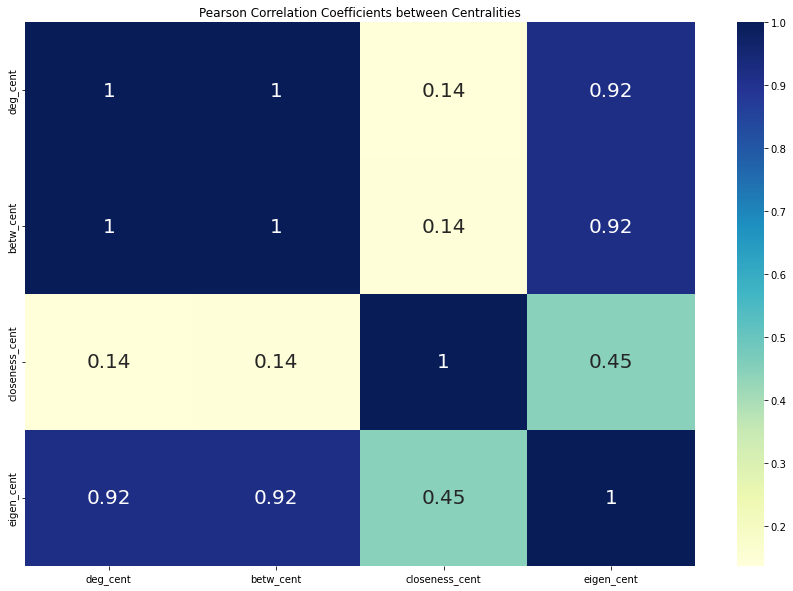

In [13]:
df=sorted_centrality_list
corr_matrix = df.corr() # default=pearson
fig, ax = plt.subplots(figsize=(15,10))   
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", annot_kws={'size': 20}) 
plt.title("Pearson Correlation Coefficients between Centralities")
plt.show()
#fig.savefig("corr_heatmap.pdf", format="pdf")

100%|██████████| 934/934 [46:47<00:00,  3.01s/it]


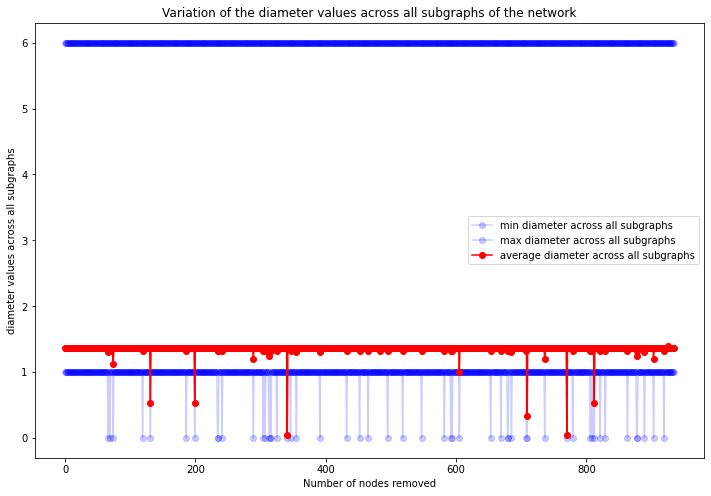

In [9]:
robustness()

In [10]:
def robustness_random_failures():
    """Robustness Random Failures

    This function calculates the relative size of the giant component of the graph w.r.t fraction of nodes randomly removed

    :return nodes_giant_comp_list: list of number of nodes of giant component
    :return removed_nodes: list of nodes removed
    :return pf_div_p0: relative size of the giant component of the graph relative to the number of nodes
    """
    G = build_graph()

    num_nodes = len(list(G.nodes()))
    removed_nodes = [0]
    nodes_giant_comp_list = []
    pf_div_p0 = []

    nodes_to_be_deleted = 1

    rem_counter = 0

    for x in tqdm(range(int(num_nodes / nodes_to_be_deleted)-1)):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            giant_comp = max(list_sub_graphs, key=len)
            giant_comp_nodes = len(list(giant_comp.nodes()))
            nodes_giant_comp_list.append(giant_comp_nodes)
            pf_div_p0.append(giant_comp_nodes / num_nodes)
            G_new = G

        G_new = remove_node_randomly(G_new, nodes_to_be_deleted)

        rem_counter = rem_counter + nodes_to_be_deleted

        list_sub_graphs = list(
            G_new.subgraph(c) for c in nx.connected_components(G_new)
        )
        giant_comp = max(list_sub_graphs, key=len)
        giant_comp_nodes = len(list(giant_comp.nodes()))
        nodes_giant_comp_list.append(giant_comp_nodes)

        percent_nodes_removed = rem_counter / num_nodes
        removed_nodes.append(percent_nodes_removed)
        pf_div_p0.append(giant_comp_nodes / num_nodes)

    return nodes_giant_comp_list, removed_nodes, pf_div_p0

In [11]:
def robustness_targeted_attacks():

    """Robustness Targeted Attacks

    This function calculates the relative size of the giant component of the graph w.r.t fraction of most central nodes removed

    :return nodes_giant_comp_list: list of number of nodes of giant component
    :return removed_nodes: list of nodes removed
    :return pf_div_p0: relative size of the giant component of the graph relative to the number of nodes
    """

    G = build_graph()
    (
        degree_centrality,
        between_centrality,
        close_centrality,
        eigen_centrality,
        token_with_max_centrality,
    ) = compute_centrality(G)

    num_nodes = len(list(G.nodes()))
    removed_nodes = [0]
    nodes_giant_comp_list = []
    pf_div_p0 = []

    nodes_to_be_deleted = 1

    rem_counter = 0

    for x in tqdm(range(int(num_nodes / nodes_to_be_deleted)-1)):

        if x == 0:
            list_sub_graphs = list(G.subgraph(c) for c in nx.connected_components(G))

            giant_comp = max(list_sub_graphs, key=len)
            giant_comp_nodes = len(list(giant_comp.nodes()))
            nodes_giant_comp_list.append(giant_comp_nodes)
            pf_div_p0.append(giant_comp_nodes / num_nodes)
            G_new = G

        G_new = remove_most_important_nodes(
            G_new, nodes_to_be_deleted + x, degree_centrality
        )

        rem_counter = rem_counter + nodes_to_be_deleted

        list_sub_graphs = list(
            G_new.subgraph(c) for c in nx.connected_components(G_new)
        )
        giant_comp = max(list_sub_graphs, key=len)
        giant_comp_nodes = len(list(giant_comp.nodes()))
        nodes_giant_comp_list.append(giant_comp_nodes)

        percent_nodes_removed = rem_counter / num_nodes
        removed_nodes.append(percent_nodes_removed)
        pf_div_p0.append(giant_comp_nodes / num_nodes)

    return nodes_giant_comp_list, removed_nodes, pf_div_p0

    

In [12]:
(
    nodes_giant_comp_list_RND,
    removed_nodes_RND,
    pf_div_p0_RND,
) = robustness_random_failures()
(
    nodes_giant_comp_list_ATTACK,
    removed_nodes_ATTACK,
    pf_div_p0_ATTACK,
) = robustness_targeted_attacks()

100%|██████████| 933/933 [00:07<00:00, 129.08it/s]


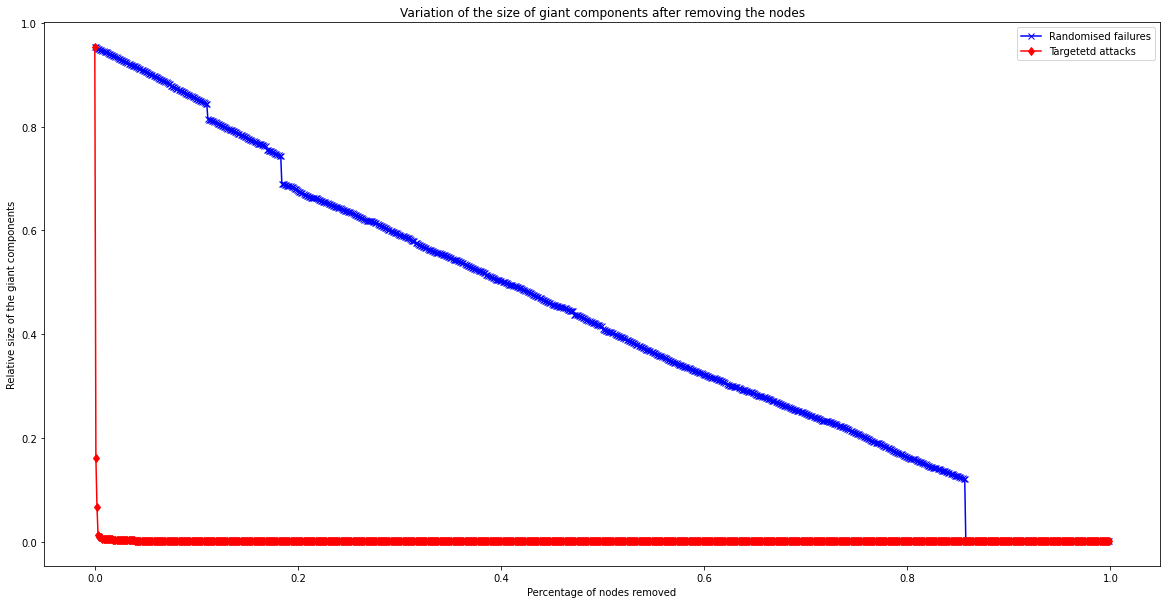

In [13]:
plt.figure(figsize=(20, 10))
plt.title("Variation of the size of giant components after removing the nodes")
plt.xlabel("Percentage of nodes removed")
plt.ylabel("Relative size of the giant components")
plt.plot(
    removed_nodes_RND,
    pf_div_p0_RND,
    linestyle="-",
    marker="x",
    label="Randomised failures",
    color="blue",
    alpha=1,
)
plt.plot(
    removed_nodes_ATTACK,
    pf_div_p0_ATTACK,
    linestyle="-",
    marker="d",
    label="Targetetd attacks",
    color="red",
    alpha=1,
)

plt.legend()
plt.show()